In [748]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [749]:
before = cv2.imread("after.jpg")
after = cv2.imread("before.jpg")
before_rgb = cv2.cvtColor(before, cv2.COLOR_BGR2RGB)
after_rgb = cv2.cvtColor(after, cv2.COLOR_BGR2RGB)

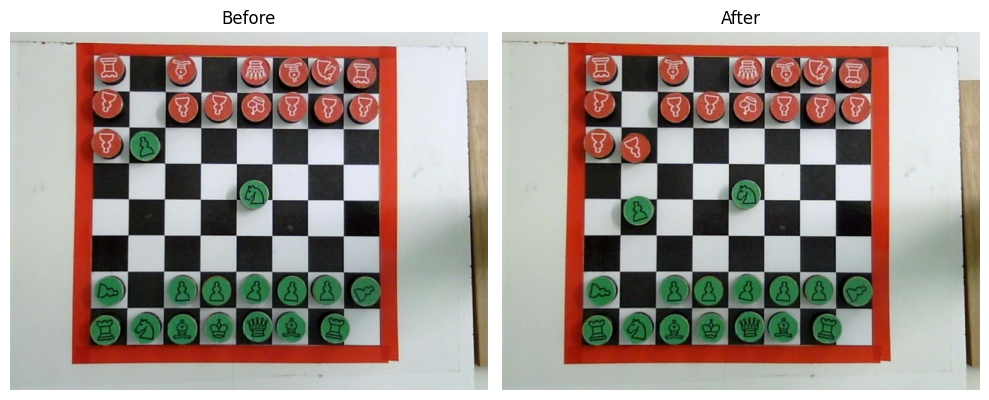

In [750]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(before_rgb)
plt.title("Before")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(after_rgb)
plt.title("After")
plt.axis("off")

plt.tight_layout()
plt.show()

In [751]:
def detect_red_regions(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define HSV ranges for the color red (two regions in HSV)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])

    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([179, 255, 255])

    # Create binary masks for both red regions
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine both masks using logical OR
    red_mask = cv2.bitwise_or(mask1, mask2)

    return red_mask

In [752]:
red_mask_before = detect_red_regions(before)
red_mask_after = detect_red_regions(after)

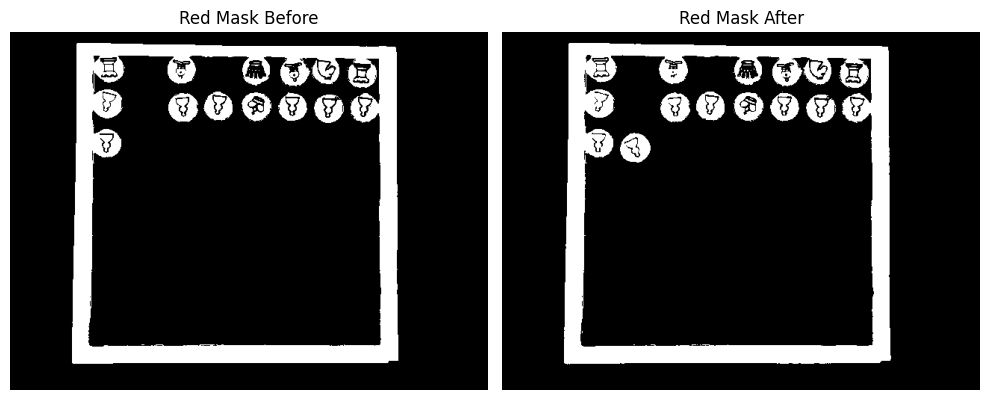

In [753]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(red_mask_before,  cmap='gray')
plt.title("Red Mask Before")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(red_mask_after,  cmap='gray')
plt.title("Red Mask After")
plt.axis("off")

plt.tight_layout()
plt.show()

In [754]:
def find_largest_red_border(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_area = 0
    border_contour = None

    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # Look for 4-sided shapes (quadrilaterals)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > largest_area:
                largest_area = area
                border_contour = approx

    if border_contour is None:
        raise Exception("❌ Red border not detected.")

    return border_contour

In [755]:
red_border_before = find_largest_red_border(red_mask_before)
red_border_after = find_largest_red_border(red_mask_after)

before_with_border = before_rgb.copy()
after_with_border = after_rgb.copy()

cv2.drawContours(before_with_border, [red_border_before], -1, (0, 255, 0), 10)
cv2.drawContours(after_with_border, [red_border_after], -1, (0, 255, 0), 10);

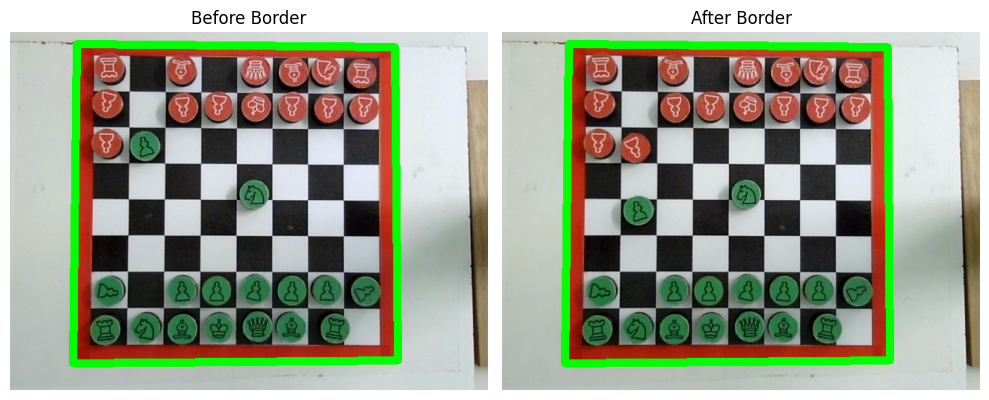

In [756]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(before_with_border)
plt.title("Before Border")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(after_with_border)
plt.title("After Border")
plt.axis("off")

plt.tight_layout()
plt.show()

In [757]:
def order_points(points):
    """
    Orders 4 points in the following order:
    top-left, top-right, bottom-right, bottom-left.

    Parameters:
        points: NumPy array with shape (4, 1, 2) or (4, 2)

    Returns:
        A NumPy array of shape (4, 2) with ordered points
    """
    points = points.reshape(4, 2)

    # Sum and difference of x + y to help find corners
    sum_coords = points.sum(axis=1)
    diff_coords = np.diff(points, axis=1)

    top_left = points[np.argmin(sum_coords)]
    bottom_right = points[np.argmax(sum_coords)]
    top_right = points[np.argmin(diff_coords)]
    bottom_left = points[np.argmax(diff_coords)]

    return np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")

def warp_perspective(image, src_points, width=800, height=800):
    """
    Applies a perspective transformation to an image based on 4 source points.

    Parameters:
        image: Original BGR image
        src_points: 4 ordered corner points (top-left, top-right, bottom-right, bottom-left)
        width: Width of the output warped image
        height: Height of the output warped image

    Returns:
        The warped BGR image
    """
    dst_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Get the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the image using the matrix
    warped = cv2.warpPerspective(image, matrix, (width, height))
    return warped

In [758]:
ordered_pts_before = order_points(red_border_before)
ordered_pts_after = order_points(red_border_after)

warped_before = warp_perspective(before_rgb, ordered_pts_before, width=800, height=800)
warped_after = warp_perspective(after_rgb, ordered_pts_after, width=800, height=800)

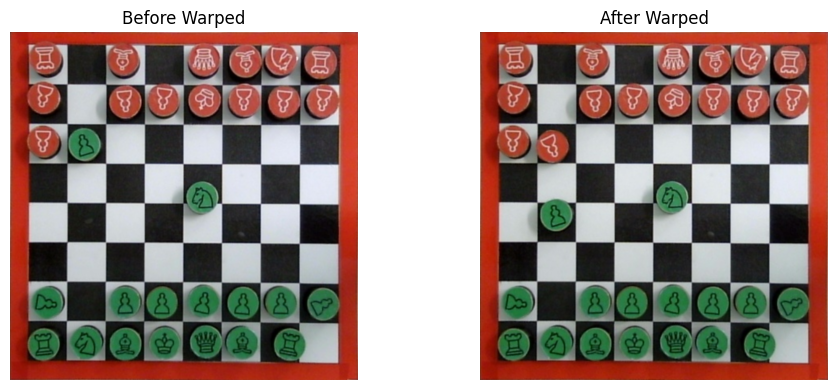

In [759]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(warped_before)
plt.title("Before Warped")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(warped_after)
plt.title("After Warped")
plt.axis("off")

plt.tight_layout()
plt.show()

In [760]:
def crop_red_border(image, border_size=40):
    """
    Crops a fixed-size red border from all sides, then resizes back
    to original image size to keep dimensions unchanged.
    """
    height, width = image.shape[:2]
    cropped = image[border_size:-border_size, border_size:-border_size]
    resized = cv2.resize(cropped, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized

def crop_red_border_custom(image, top=40, bottom=20, left=40, right=40):
    """
    Crops a custom border from each side, then resizes back to original size.
    """
    height, width = image.shape[:2]
    cropped = image[top:height - bottom, left:width - right]
    resized = cv2.resize(cropped, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized


In [761]:
before_cropped = crop_red_border_custom(warped_before,  29, 43, 43, 43 )
after_cropped = crop_red_border_custom(warped_after, 29, 43, 43, 43)

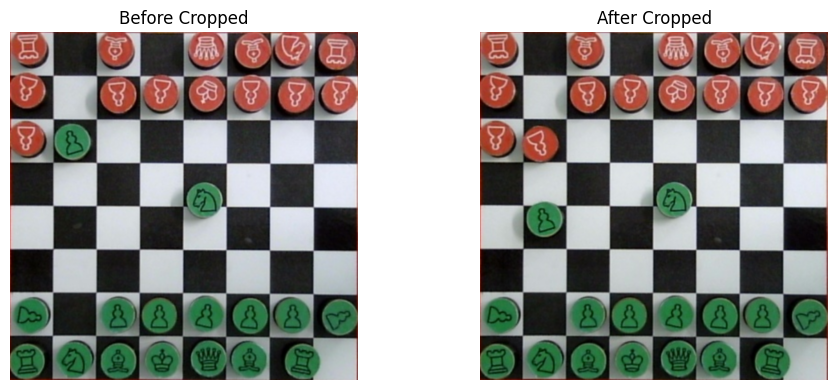

In [762]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(before_cropped)
plt.title("Before Cropped")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(after_cropped)
plt.title("After Cropped")
plt.axis("off")

plt.tight_layout()
plt.show()

In [763]:
before = before_cropped[:, :, ::-1].copy()
after = after_cropped[:, :, ::-1].copy()

height, width = before.shape[:2]

cell_w = width // 8
cell_h = height // 8

print(cell_w, cell_h)

100 100


In [764]:
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

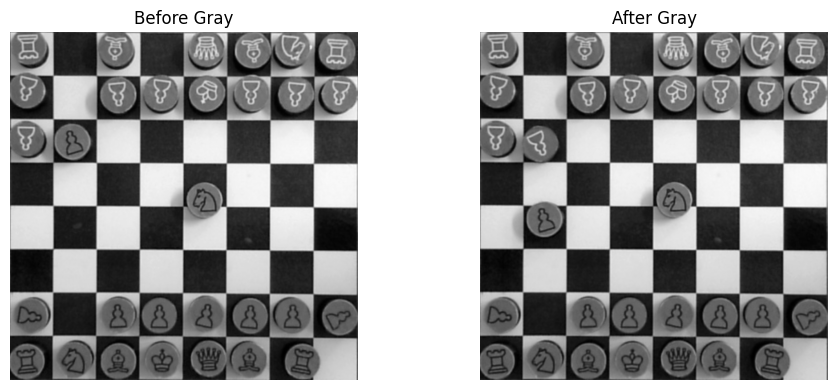

In [765]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(before_gray, cmap='gray')
plt.title("Before Gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(after_gray, cmap='gray')
plt.title("After Gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [766]:
def preprocess_diff(gray1, gray2, blur_ksize=(9,9), threshold_val=60, morph_kernel_size=(5,5)):
    """
    Takes two grayscale images, applies Gaussian blur, computes absolute difference,
    thresholds and applies morphological opening and closing.
    Returns the binary mask.
    """
    gray1_blur = cv2.GaussianBlur(gray1, blur_ksize, 0)
    gray2_blur = cv2.GaussianBlur(gray2, blur_ksize, 0)
    diff = cv2.absdiff(gray1_blur, gray2_blur)
    
    _, thresh = cv2.threshold(diff, threshold_val, 255, cv2.THRESH_BINARY)
    kernel = np.ones(morph_kernel_size, np.uint8)
    
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    return thresh

def draw_contours(image_rgb, binary_mask, contour_color=(255, 0, 0), thickness=2):
    """
    Finds contours in the binary mask and draws them on a copy of the input image.
    Returns the image with contours and the list of contours.
    """
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = image_rgb.copy()
    cv2.drawContours(output, contours, -1, contour_color, thickness)
    return output, contours

def draw_centers(image_rgb, contours, min_area=2000, center_color=(255, 0, 0), radius=15):
    """
    Filters contours by minimum area, calculates their centers,
    draws filled circles on the image at those centers.
    Returns the image with centers drawn and a list of center coordinates.
    """
    output = image_rgb.copy()
    centers = []
    
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centers.append((cx, cy))
            cv2.circle(output, (cx, cy), radius, center_color, -1)
    
    return output, centers

In [767]:
thresh = preprocess_diff(before, after)

thresh_gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

output_contours, contours = draw_contours(before, thresh_gray)
output_centers, centers = draw_centers(before, contours)

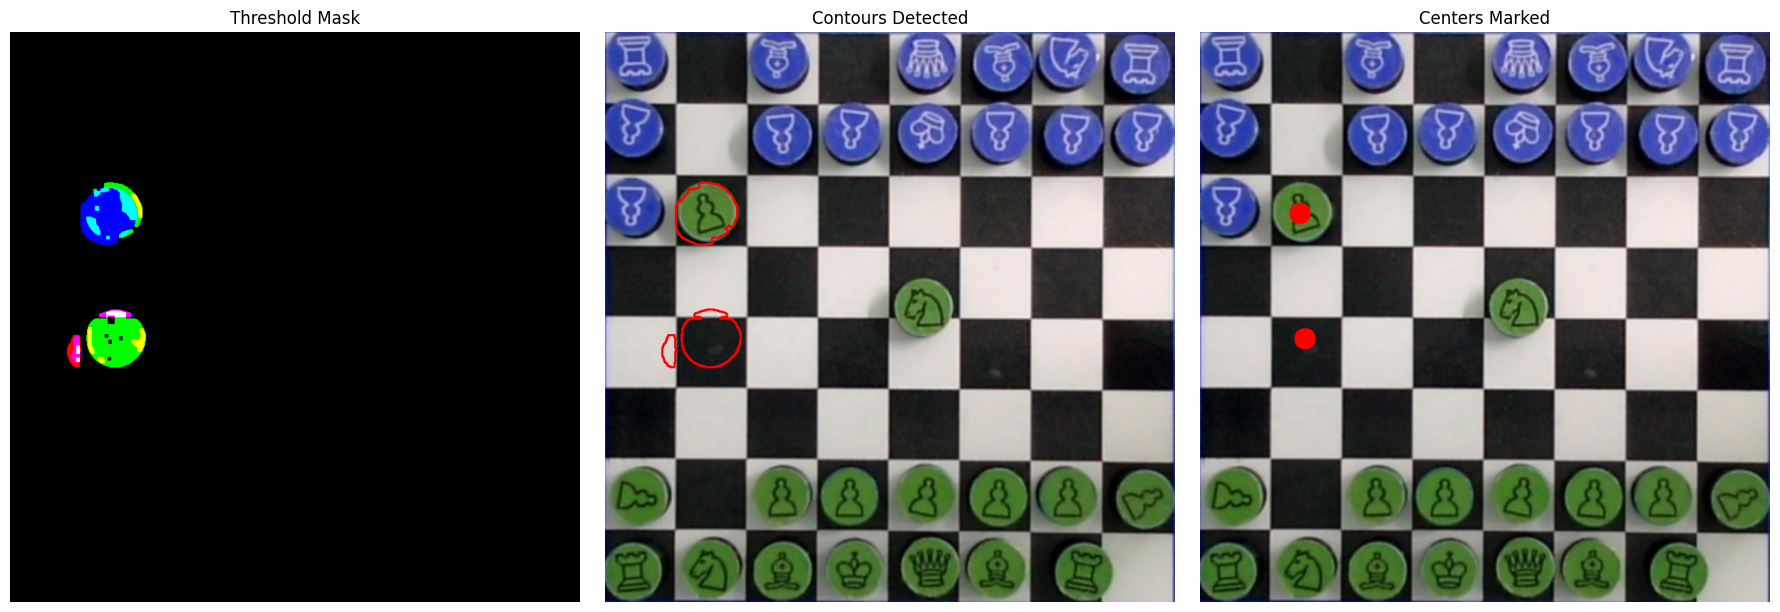

In [768]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(thresh, cmap='gray')
plt.title("Threshold Mask")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(output_contours)
plt.title("Contours Detected")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_centers)
plt.title("Centers Marked")
plt.axis('off')

plt.tight_layout()
plt.show()

In [769]:
def get_changed_squares(centers, cell_width, cell_height):
    """
    Converts center coordinates (x, y) into board grid positions (row, col)
    based on cell dimensions.

    Parameters:
        centers: List of (x, y) center coordinates
        cell_width: Width of one board cell
        cell_height: Height of one board cell

    Returns:
        List of (row, col) tuples indicating changed squares
    """
    squares = []
    for cx, cy in centers:
        col = cx // cell_width
        row = cy // cell_height
        squares.append((int(row), int(col)))
    
    return squares

def convert_to_chess_notation(squares):
    """
    Converts a list of (row, col) positions to standard chess notation (e.g. 'e4').

    Parameters:
        squares: List of (row, col) tuples where (0,0) is top-left of the board.

    Returns:
        List of strings in chess notation.
    """
    def to_notation(row, col):
        col_letter = chr(ord('a') + col)  # a-h
        row_number = 8 - row              # 8-1
        return f"{col_letter}{row_number}"
    
    return [to_notation(r, c) for r, c in squares]

In [770]:
changed_squares = get_changed_squares(centers, cell_w, cell_h)
print(convert_to_chess_notation(changed_squares))

['b4', 'b6']
